In [1]:
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [2]:
import numpy as np
import pandas as pd
import random
import calendar
import openpyxl
import matplotlib.pyplot as plt
from scipy.stats import mstats
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.gofplots import qqline
import warnings
import math
warnings.filterwarnings('ignore')

In [3]:
############################################################################################
# Settings for the calculations that can be changed
lags =16  # months of lagged FC
Minimum_Number_Stocks = 0.2  # Firm characteritics that are avvailable for at least 20% of stocks

Upper_limit = 0.98       # FC upper outliers
Lower_limit = 1-Upper_limit # FC lower outliers

def winsorize_df(df):
    return df.apply(winsorize_series, axis=0)

def winsorize_series(s):
    return mstats.winsorize(s, limits=[1-Upper_limit, Lower_limit])

In [4]:
############################################################################################
# Read Data

# # Colab 사용할 경우 구글드라이버 폴더에 접근하게 함
from google.colab import drive
drive.mount('/gdrive')
df = pd.read_excel("/gdrive//MyDrive/QuantFinance/QuantDataR.xlsx", None, index_col=0 )

# # 자산의 컴퓨터에 저장된 데이터 읽기
# data= 'QuantDataR.xlsx'
# df = pd.read_excel(data, None, index_col=0 )  # 자신의 컴퓨터에 설치된 파이썬을 사용하는 경우. 파이썬 코드와 데이터 화일의 위치가 동일해야함. 아니면 폴더 경로를 명시

print("==========================================================================")
print("Spreadsheet 확인")
df_names = list(df.keys())
print(df_names)

Mounted at /gdrive
Spreadsheet 확인
['D_Market', 'D_RI', 'D_TradingValue', 'D_P', 'M_Market', 'Beta', 'Volatility', 'DY', 'RI', 'TradingValue', 'Cash', 'AccReceivables', 'Inventory', 'CurrentAsset', 'R&D', 'Plants', 'Intangible', 'Total Asset', 'AccPayable', 'CurrentLiability', 'LongTermDebt', 'TotalLiability', 'CommonEquity', 'TotalShareEqu', 'Sales', 'CoGS', 'DepArm', 'OperatingIncome', 'EBIT', 'Interest', 'NetIncome', 'DividendPerShare', 'EPS', 'CommonShares', 'Investment', 'Employee', 'WorkingCap', 'MarketValue']


In [5]:
# 개별주식의 총수익률 (RI) 데이터 읽음
RID = df['RI']
print("--------------------------------------------------------------------------")
print("데이터형식 확인")
print(RID)

# Dates
date = RID.index
print("--------------------------------------------------------------------------")
print("Dates")
print(date)

#firm names using 'D_Price'
D_Price = df['D_P']
firm_names =  D_Price.columns
print("--------------------------------------------------------------------------")
print("FIrm Names")
print(firm_names)


--------------------------------------------------------------------------
데이터형식 확인
            A SELF-ADMINISTERED REIT.TST. - TOT RETURN IND  \
Name                                                         
2006-08-31                                             NaN   
2006-09-29                                             NaN   
2006-10-31                                             NaN   
2006-11-30                                             NaN   
2006-12-29                                             NaN   
...                                                    ...   
2020-05-29                                          171.99   
2020-06-30                                          167.76   
2020-07-31                                          170.41   
2020-08-31                                          173.85   
2020-09-30                                          198.19   

            ABLE C&C - TOT RETURN IND  AEKYUNG IND - TOT RETURN IND  \
Name                                  

In [6]:
############################################################################################
# Calculation of log-returns

R = []
print("Null stocks: ", end ='')    # end=''  다음 출력이 같은 줄에 프린트하기
for i in range(0,RID.shape[1]):

    if RID.shape[0] - RID.iloc[:, i ].isnull().sum() < 2:   # 전체 T개의 관찰치중 NA개수를 뺀 나머지가 2 보다 작으면 계산하지 않음

        print (i, ", ", end='')
        R_temp = pd.Series([np.nan]*(RID.shape[0]-1))    #전체를 NA로 대체
        R.append(R_temp)
        continue            # 반복문 내에서만 사용되며, 반복이 진행되는 도중 continue문을 만나면 반복문의 끝으로 이동하여 다음 반복문(i+1)으로 넘어감.

    log0 = (np.log(RID.iloc[1:, i ])).reset_index(drop =True)     # drop=True옵션을 주면 기존 인덱스를 버리고 재배열
    log1 = (np.log(RID.iloc[0:-1, i ])).reset_index(drop =True)

    R_temp =  (log0-log1)*100
    R.append(R_temp)

print(sep ='')   # print문의 출력문들 사이에 ''안의 내용 삽입

R = pd.concat(R,axis= 1)   # R이라는 matrix는 각 개별주식의 수익률 벡터를 순차적으로 오른편으로 덧붙여 작성. axis=0 이면 아래쪽으로 붙임
R.index = date[1:]         # 첫달 제외
R.columns = firm_names     # 회사이름

print("=========================================================================")
print("Return Data")
print(R)

R = R.replace([np.inf, -np.inf], np.nan)    # 혹시 가격이 0인 경우 발생할 수 있는 수익률을 nan으로 교체

Null stocks: 25 , 747 , 
Return Data
            A SELF-ADMINISTERED REIT.TST.   ABLE C&C  AEKYUNG IND  AIR BUSAN  \
Name                                                                           
2006-09-29                            NaN   4.372000          NaN        NaN   
2006-10-31                            NaN  24.040686          NaN        NaN   
2006-11-30                            NaN -13.268377          NaN        NaN   
2006-12-29                            NaN  -9.720986          NaN        NaN   
2007-01-31                            NaN -14.786239          NaN        NaN   
...                                   ...        ...          ...        ...   
2020-05-29                      14.543823  -9.827651   -13.454202  -3.198141   
2020-06-30                      -2.490195   0.864266    -6.181051   0.513237   
2020-07-31                       1.567291 -10.800751    -3.692683  -4.083322   
2020-08-31                       1.998556  -9.177773    -3.591237  -1.484441   
202

In [7]:
# Choose one date for testing
random.seed(100)
rndate = random.randint(121,len(date)-24)   #Randomly Selecting a month from 2015 excluding 2019 and 2020
rndate = 109

print(date[rndate]) #Print the selected month

# The detailed explanation of reading the data and calculating returns can be found in the previously recorded lecture.

2015-09-30 00:00:00


In [8]:
#Delete Marekt data and Returns(9), Investment(35)','Employee(36)'
remove_set = ['D_Market', 'D_RI','D_TradingValue','D_P', 'M_Market',"RI", "Investment","Employee"]
FC_name = [i for i in df_names if i not in remove_set]


print("--------------------------------------------------------------------------")
print("FIrm Characteristics Names")
print(FC_name)

--------------------------------------------------------------------------
FIrm Characteristics Names
['Beta', 'Volatility', 'DY', 'TradingValue', 'Cash', 'AccReceivables', 'Inventory', 'CurrentAsset', 'R&D', 'Plants', 'Intangible', 'Total Asset', 'AccPayable', 'CurrentLiability', 'LongTermDebt', 'TotalLiability', 'CommonEquity', 'TotalShareEqu', 'Sales', 'CoGS', 'DepArm', 'OperatingIncome', 'EBIT', 'Interest', 'NetIncome', 'DividendPerShare', 'EPS', 'CommonShares', 'WorkingCap', 'MarketValue']


In [9]:
FCS = []
FCS_lagged =[]

for i in FC_name:
    FC_data = df[i]

    FC = FC_data.iloc[rndate,:].reset_index(drop =True)  # drop=True옵션을 주면 기존 인덱스를 버리고 재배
    FCS.append(FC)

    FC_lagged = FC_data.iloc[rndate-lags,:].reset_index(drop =True)
    FCS_lagged.append(FC_lagged)


FCS = pd.concat(FCS, axis = 1 )
FCS_lagged = pd.concat(FCS_lagged, axis = 1 )

FCS.columns = FC_name
FCS_lagged.columns = FC_name

FCS.index = firm_names
FCS_lagged.index = firm_names

FCS

,Beta,Volatility,DY,TradingValue,Cash,AccReceivables,Inventory,CurrentAsset,R&D,Plants,...,DepArm,OperatingIncome,EBIT,Interest,NetIncome,DividendPerShare,EPS,CommonShares,WorkingCap,MarketValue
A SELF-ADMINISTERED REIT.TST.,0.7,0.3064,0.29,314.8,4105363.0,16417025.0,10693154.0,NaN,NaN,4061.0,...,12076.0,7303243.0,8773091.0,816172.0,6866116.0,910.819,1200.36,3793.0,NaN,20320.91
ABLE C&C,0.79,0.549,0.03,465261.1,118296189.0,24576917.0,42210495.0,188169258.0,2894843.0,20901286.0,...,4908955.0,17695243.0,20425914.0,0.0,15589448.0,238.211,641.99,15743.0,131916816.0,391401.70
AEKYUNG IND,NaN,NaN,NaN,NaN,3943901.0,55870633.0,61582448.0,122406595.0,8485000.0,56352744.0,...,5775791.0,24403992.0,24721188.0,2035625.0,17192684.0,NaN,NaN,21322.0,23708199.0,NaN
AIR BUSAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AJ NETWORKS,NaN,0.0,0.0,61386.4,86969599.0,103794573.0,27088621.0,252774438.0,NaN,1357205727.0,...,284962094.0,72828503.0,78535895.0,40278706.0,18824358.0,NaN,NaN,46822.0,-564327147.0,410631.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUHWA SECURITIES,0.27,0.1418,4.14,694.6,38197217.0,33699929.0,0.0,NaN,NaN,7437479.0,...,595501.0,10613933.0,14984525.0,1702614.0,8196446.0,140.0,173.52,51744.0,NaN,164436.90
YUNGJIN PHARM,0.47,0.4376,0,83920.6,4523038.0,54709761.0,33105877.0,93804906.0,12635620.0,70173368.0,...,5861324.0,5047840.0,5420720.0,951381.0,3386324.0,0.0,20.18,177620.0,51584891.0,361456.60
YUYANG D&U SUSP - SUSP.20/03/20,0.69,0.5206,0.0,40858.2,9820602.0,27902268.0,25180133.0,63718551.0,3807349.0,25562775.0,...,3666727.0,3948284.0,4194184.0,2374567.0,1617387.0,0.0,0.0,37372.0,11558275.0,53255.57
YUYU PHARMA,0.95,0.3967,1.25,38758.4,10333291.0,25250113.0,12789107.0,49015687.0,2074000.0,47225560.0,...,1542171.0,1487145.0,15409.0,296910.0,-498715.0,180.0,0.0,5711.0,19808898.0,88145.25


In [10]:
# Remove firms whose returns are not available
R_test = R.iloc[rndate,:]
ST = R_test.notnull().values

R_test = R_test[ST]

FCS = FCS[ST].astype(float)  # conver type from object to float
FCS_lagged = FCS_lagged[ST].astype(float)  # conver type from object to float



In [11]:
# FCS.loc[:,'Total Asset'] = np.log(FCS.loc[:,'Total Asset'])
# FCS_lagged.loc[:,'Total Asset'] =  np.log(FCS_lagged.loc[:,'Total Asset'])

for i in FCS.columns:
    if i != 'Total Asset':
        FCS.loc[:,i] = (FCS.loc[:,i]/FCS.loc[:,'Total Asset'])* 100
        FCS_lagged.loc[:,i] = (FCS_lagged.loc[:,i]/FCS_lagged.loc[:,'Total Asset'])* 100

FCS

,Beta,Volatility,DY,TradingValue,Cash,AccReceivables,Inventory,CurrentAsset,R&D,Plants,...,DepArm,OperatingIncome,EBIT,Interest,NetIncome,DividendPerShare,EPS,CommonShares,WorkingCap,MarketValue
A SELF-ADMINISTERED REIT.TST.,1.194364e-06,5.227903e-07,4.948081e-07,0.000537,7.004713,28.011299,18.245031,NaN,NaN,0.006929,...,0.020604,12.461047,14.968953,1.392581,11.715206,0.001554,0.002048,0.006472,NaN,0.034672
ABLE C&C,3.205836e-07,2.227853e-07,1.217406e-08,0.188804,48.004828,9.973362,17.129103,76.359458,1.174733,8.481783,...,1.992064,7.180765,8.288876,0.000000,6.326229,0.000097,0.000261,0.006389,53.532105,0.158832
AJ NETWORKS,NaN,0.000000e+00,0.000000e+00,0.003569,5.056541,6.034769,1.574972,14.696678,NaN,78.909940,...,16.568116,4.234356,4.566193,2.341863,1.094476,NaN,NaN,0.002722,-32.810811,0.023875
AJU CAPITAL,5.820800e-09,3.275265e-09,6.161530e-08,0.000016,6.813143,16.939682,0.000000,NaN,NaN,9.259682,...,0.123884,0.935953,4.185353,3.277930,0.654305,0.000006,0.000011,0.000813,NaN,0.005654
AK HOLDINGS,4.690513e-08,2.115987e-08,1.779160e-08,0.003621,17.466922,10.099531,8.221165,39.189192,0.590762,38.047078,...,2.962702,4.003925,1.250972,2.055168,-1.738650,0.000020,0.000198,0.000521,-10.661871,0.042907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUHAN,2.820724e-08,1.573219e-08,3.831926e-08,0.007014,25.543305,12.527396,12.898100,51.059550,3.866148,16.383005,...,1.597134,4.568368,9.126391,0.166646,6.579811,0.000018,0.000084,0.003247,32.079207,0.144530
YUHWA SECURITIES,4.439080e-08,2.331339e-08,6.806590e-07,0.000114,6.280019,5.540618,0.000000,NaN,NaN,1.222799,...,0.097907,1.745041,2.463611,0.279927,1.347581,0.000023,0.000029,0.008507,NaN,0.027035
YUNGJIN PHARM,2.490545e-07,2.318856e-07,0.000000e+00,0.044470,2.396772,28.990875,17.542909,49.707517,6.695655,37.185090,...,3.105934,2.674866,2.872457,0.504140,1.794424,0.000000,0.000011,0.094121,27.334997,0.191537
YUYANG D&U SUSP - SUSP.20/03/20,7.139961e-07,5.387049e-07,0.000000e+00,0.042279,10.162132,28.872623,26.055820,65.934485,3.939757,26.451769,...,3.794244,4.085593,4.340045,2.457147,1.673635,0.000000,0.000000,0.038672,11.960236,0.055108


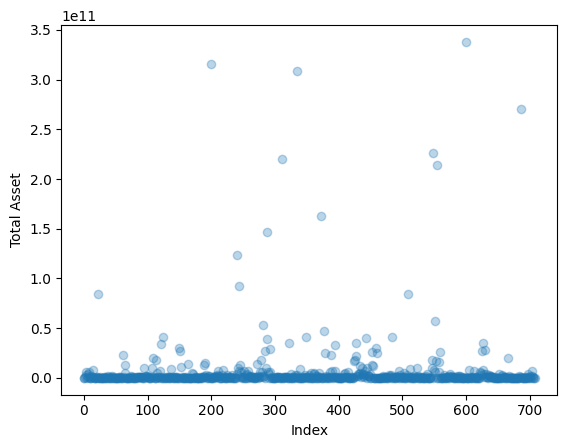

In [12]:
# Selection of Firm Characteristics that are available for at least Minimum_Number_Stocks
Selected_FC = (FCS.isnull().sum(axis =0 )  <= Minimum_Number_Stocks * len(R_test)).values

FCS = FCS.iloc[:,Selected_FC]
FCS_lagged = FCS_lagged.iloc[:,Selected_FC]

plt.scatter(range(0,len(FCS_lagged['Total Asset'])),FCS_lagged['Total Asset'], alpha=0.3)
plt.xlabel("Index")
plt.ylabel("Total Asset")
plt.show()

# FCS_lagged['Total Asset']

In [13]:
##################### Data Preprocessing ##########################
## for Contemporaneous FCs

# it is just for FCS data, if you want to preprocess  FCS_lagged , you should only change 'FCS_lagged' to 'FCS' , 'FCS_lagged_name' to'FCS_name'

# Winsorizing FC (to control outliers)
WFCS = winsorize_df(FCS)

# Nomalization
NWFCS = (WFCS -np.mean(WFCS))/np.std(WFCS )

# Replacing NA  to 0
NWFCS = NWFCS.fillna(0)

# Check the Winsorized and Normalized FC
NWFCS.describe()


## for Lagged FCs

# Winsorizing FC (to control outliers)
WFCS_lagged = winsorize_df(FCS_lagged)

# Nomalization
NWFCS_lagged = (WFCS_lagged -np.mean(WFCS_lagged))/np.std(WFCS_lagged )

# Replacing NA  to 0
NWFCS_lagged = NWFCS_lagged.fillna(0)

# Check the Winsorized and Normalized FC
NWFCS_lagged.describe()

,Beta,Volatility,DY,TradingValue,Cash,AccReceivables,Inventory,CurrentAsset,Plants,Intangible,...,DepArm,OperatingIncome,EBIT,Interest,NetIncome,DividendPerShare,EPS,CommonShares,WorkingCap,MarketValue
count,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,...,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02,7.090000e+02
mean,-2.505440e-17,-5.511968e-17,2.004352e-17,1.127448e-17,1.252720e-17,5.010880e-18,3.257072e-17,-1.553373e-16,-9.520671e-17,1.102394e-16,...,4.008704e-17,2.505440e-17,-8.017407e-17,-1.503264e-17,5.010880e-18,3.382344e-17,-1.002176e-17,2.505440e-18,-3.758160e-17,-1.002176e-17
std,9.850579e-01,9.857745e-01,9.864907e-01,9.829047e-01,9.836230e-01,9.836230e-01,9.836230e-01,9.633100e-01,1.000706e+00,1.000706e+00,...,1.000706e+00,1.000706e+00,1.000706e+00,1.000706e+00,1.000706e+00,1.000706e+00,9.857745e-01,1.000706e+00,9.633100e-01,9.864907e-01
min,-5.572851e-01,-3.787632e-01,-3.054927e-01,-2.670933e-01,-9.207261e-01,-1.524585e+00,-1.227618e+00,-2.104228e+00,-1.629108e+00,-6.242775e-01,...,-1.195140e+00,-2.801101e+00,-3.204383e+00,-9.991003e-01,-3.488070e+00,-4.418211e-01,-2.863117e-01,-5.986857e-01,-2.155912e+00,-3.087386e-01
25%,-4.530304e-01,-3.446395e-01,-3.054927e-01,-2.455985e-01,-6.550351e-01,-6.523454e-01,-7.388859e-01,-6.190598e-01,-7.199783e-01,-5.352368e-01,...,-6.740943e-01,-5.020685e-01,-4.019713e-01,-7.346535e-01,-2.755769e-01,-4.418211e-01,-2.863117e-01,-5.476916e-01,-6.237757e-01,-2.078924e-01
50%,-2.823291e-01,-2.515928e-01,-2.653177e-01,-1.977683e-01,-3.005907e-01,-1.191532e-01,-7.931186e-02,0.000000e+00,-1.074705e-03,-3.805937e-01,...,-2.397536e-01,-1.234177e-02,-4.752814e-03,-2.884159e-01,1.809259e-02,-3.649541e-01,-2.409046e-01,-3.824014e-01,0.000000e+00,-1.163574e-01
75%,5.740913e-02,-7.316057e-03,-2.661138e-02,-5.219354e-02,2.861537e-01,4.886100e-01,4.338957e-01,5.953521e-01,6.313312e-01,5.709683e-02,...,4.495598e-01,5.077126e-01,4.864319e-01,4.225116e-01,4.916633e-01,-8.405839e-02,-7.075472e-02,6.933266e-02,5.914113e-01,2.241533e-02
max,1.461220e+01,1.476262e+01,1.510191e+01,1.457086e+01,5.202134e+00,4.872065e+00,5.572740e+00,2.988081e+00,2.509443e+00,4.404617e+00,...,3.916696e+00,2.735928e+00,2.686092e+00,3.730319e+00,2.444621e+00,5.089196e+00,1.576919e+01,4.520000e+00,3.643310e+00,2.484834e+01


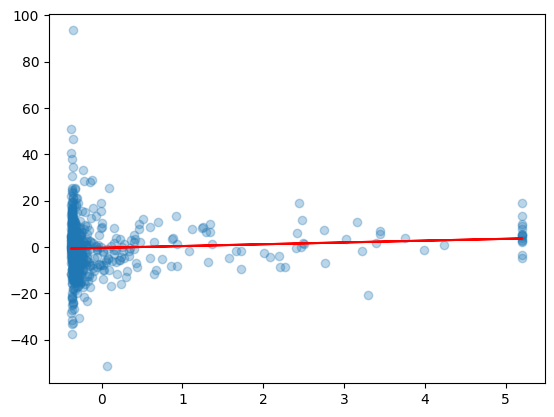

In [14]:
## ==========================================================
# Pre-screen the data with contemporaneous FCs  : 두변수간 분포비교
from statsmodels.graphics.gofplots import qqline
ax = plt.subplot(111)
plt.scatter(NWFCS['Total Asset'],R_test, alpha=0.3)    # plt.scatter(X,Y,s=S, c=C, label='A')
qqline(ax, "r",  NWFCS['Total Asset'],R_test)   # Y: returns, X: size


Test_FC Volatility
Mean: -5.0108796598032455e-17   SD: 1.000705965495625   skwness: 2.9660182773938493  kurtosis: 9.286555416130016


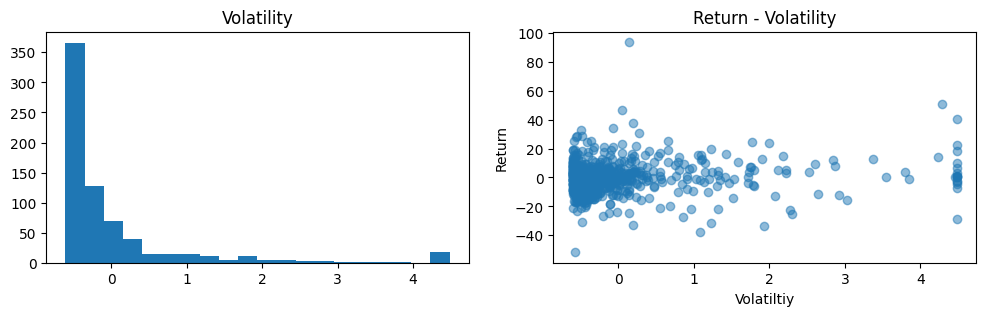

In [15]:
Test_FC = NWFCS['Volatility']

print('Test_FC Volatility')
print("Mean:", Test_FC.mean(), "  SD:",Test_FC.std(),"  skwness:",Test_FC.skew()," kurtosis:",Test_FC.kurtosis())

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.hist(Test_FC,bins=20)
plt.title('Volatility')

# scatterplot (returns-FC)
plt.subplot(1, 2, 2)
plt.scatter(Test_FC,R_test, alpha=0.5)
plt.xlabel("Volatiltiy")
plt.ylabel("Return")
plt.title('Return - Volatility')

plt.show()

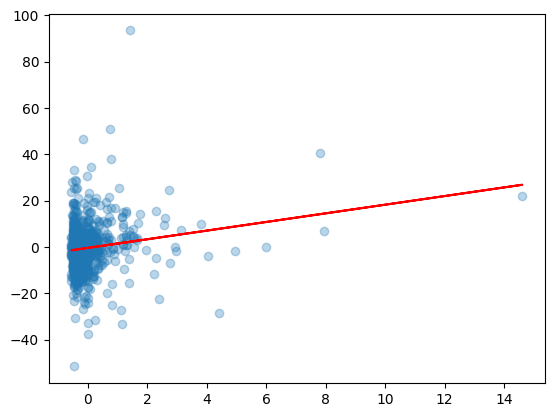

In [16]:
## ==========================================================
# Pre-screen the data with lagged FCs
from statsmodels.graphics.gofplots import qqline
ax = plt.subplot(111)
plt.scatter(NWFCS_lagged['Beta'],R_test, alpha=0.3)
qqline(ax, "r",  NWFCS_lagged['Beta'],R_test)


Test_FC_lagged Volatility
Mean: -5.51196762578357e-17   SD: 0.9857745241328663   skwness: 8.447847059535789  kurtosis: 97.15464612018191


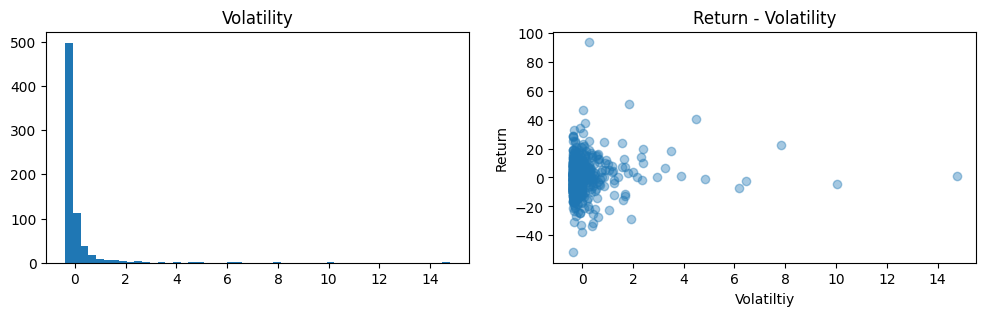

In [17]:
Test_FC_lagged = NWFCS_lagged['Volatility']

print('Test_FC_lagged Volatility')
print("Mean:", Test_FC_lagged .mean(), "  SD:",Test_FC_lagged .std(),"  skwness:",Test_FC_lagged .skew()," kurtosis:",Test_FC_lagged .kurtosis())

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.hist(Test_FC_lagged,bins=50)
plt.title('Volatility')

# scatterplot (returns-FC)
plt.subplot(1, 2, 2)
plt.scatter(Test_FC_lagged,R_test, alpha=0.4)
plt.xlabel("Volatiltiy")
plt.ylabel("Return")
plt.title('Return - Volatility')

plt.show()

                             OLS Regression Results                            
Dep. Variable:     2015-10-30 00:00:00   R-squared:                       0.020
Model:                             OLS   Adj. R-squared:                  0.019
Method:                  Least Squares   F-statistic:                     14.47
Date:                 Sat, 23 Sep 2023   Prob (F-statistic):           0.000155
Time:                         05:52:07   Log-Likelihood:                -2699.3
No. Observations:                  709   AIC:                             5403.
Df Residuals:                      707   BIC:                             5412.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4251      0.410     -1.03

Text(0, 0.5, 'Returns')

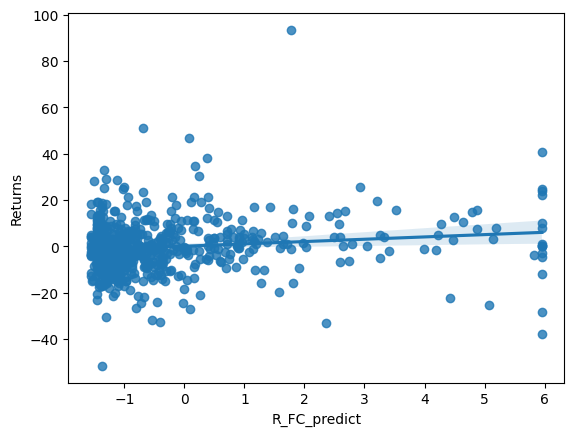

In [18]:
#############################################################
## Regression with contemporaneous FCs
# Using OLS function in python
Returns = R_test

# Univariate Regression with a contemporaneous FC
X = NWFCS['Beta']
model = sm.OLS(Returns ,sm.add_constant(X))
result = model.fit()
print(result.summary())

R_FC_predict = result.predict()
sns.regplot(x= R_FC_predict,
            y= Returns,
            fit_reg=True) # default
plt.xlabel("R_FC_predict")
plt.ylabel("Returns")

                             OLS Regression Results                            
Dep. Variable:     2015-10-30 00:00:00   R-squared:                       0.042
Model:                             OLS   Adj. R-squared:                  0.035
Method:                  Least Squares   F-statistic:                     6.094
Date:                 Sat, 23 Sep 2023   Prob (F-statistic):           1.55e-05
Time:                         05:52:14   Log-Likelihood:                -2691.5
No. Observations:                  709   AIC:                             5395.
Df Residuals:                      703   BIC:                             5422.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4251      0.406    

Text(0, 0.5, 'Returns')

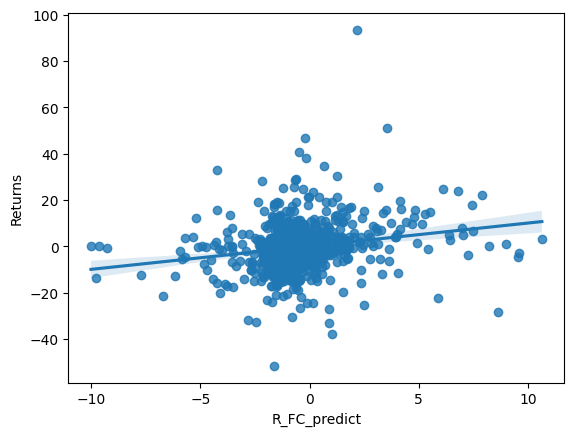

In [19]:
# Multi-variate Regression with contemporaneous FCs
X = NWFCS[["Beta","Volatility","DY","TradingValue","Cash"]]
model = sm.OLS(Returns ,sm.add_constant(X))
result = model.fit()
print(result.summary())

R_FC_predict = result.predict()
sns.regplot(x= R_FC_predict,
            y= Returns,
            fit_reg=True) # default
plt.xlabel("R_FC_predict")
plt.ylabel("Returns")

                             OLS Regression Results                            
Dep. Variable:     2015-10-30 00:00:00   R-squared:                       0.120
Model:                             OLS   Adj. R-squared:                  0.083
Method:                  Least Squares   F-statistic:                     3.198
Date:                 Sat, 23 Sep 2023   Prob (F-statistic):           5.91e-08
Time:                         05:52:20   Log-Likelihood:                -2661.1
No. Observations:                  709   AIC:                             5382.
Df Residuals:                      679   BIC:                             5519.
Df Model:                           29                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.4251   

Text(0, 0.5, 'Returns')

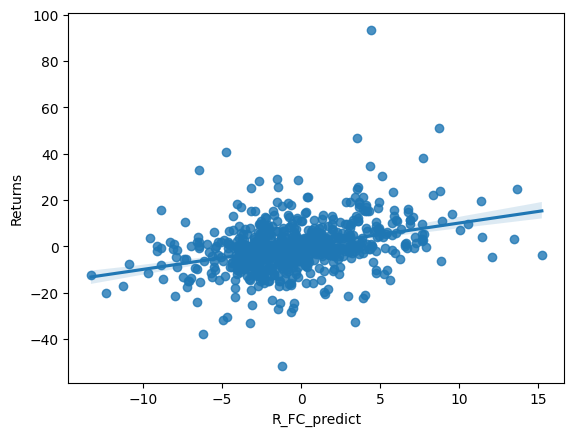

In [20]:
# Regression with All contemporaneous FCs
X = NWFCS
model = sm.OLS(Returns ,sm.add_constant(X))
result = model.fit()
print(result.summary())

R_FC_predict = result.predict()
sns.regplot(x= R_FC_predict,
            y= Returns,
            fit_reg=True) # default
plt.xlabel("R_FC_predict")
plt.ylabel("Returns")

